In [23]:
import re
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import contractions
from spellchecker import SpellChecker
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, VotingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score
from imblearn.over_sampling import SMOTE
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from add_features import medication_score, add_tweet_info

### Importação dos datasets

- `df_train`: dataset de treino
- `df_test`: dataset de teste

In [24]:
df_train = pd.read_csv('task1_training.csv', delimiter = '\t')
df_test = pd.read_csv('task1_testing.csv', delimiter = '\t')


In [25]:
print(df_train['class'].value_counts())
print()
print(df_test['label'].value_counts())


class
0    55273
1      146
Name: count, dtype: int64

label
0    13817
1       36
Name: count, dtype: int64


#### Feature engineering

In [26]:
add_tweet_info(df_train)
add_tweet_info(df_test)

### Pré processamento do texto

Processamento básico:

- minúsculas
- remover urls
- remover usernames
- remover pontuaçao repetida (exemplo: 'YES!!!' -> 'YES!')
- separar pontuação
- remover símbolos •‘’“”
- remover &amp &lt &gt
- remover #

In [27]:
from process import BasicPreprocessor

processing = BasicPreprocessor()
processing.preprocess(df_train, 'tweet')
processing.preprocess(df_test, 'tweet')

#### Tokenization

In [28]:
def lemma_tokenizer(text):
    res = list()

    #criar tokens
    tokens = word_tokenize(text)

    #lemmatizer
    lemmatizer = WordNetLemmatizer()
    for token in tokens:
        res.append(lemmatizer.lemmatize(token))
    return res


df_train['tweet'] = df_train['tweet'].apply(lemma_tokenizer)
df_test['tweet'] = df_test['tweet'].apply(lemma_tokenizer)

In [29]:
#remove stopwords
def remove_stopwords(original_sentence):
    stop_words = set(stopwords.words('english'))
    filtered_sentence = list()

    for word in original_sentence:
        if word not in stop_words:
            filtered_sentence.append(word)

    return filtered_sentence
    

df_train['tweet'] = df_train['tweet'].apply(remove_stopwords)
df_test['tweet'] = df_test['tweet'].apply(remove_stopwords)

#### Wordcloud

Training dataset


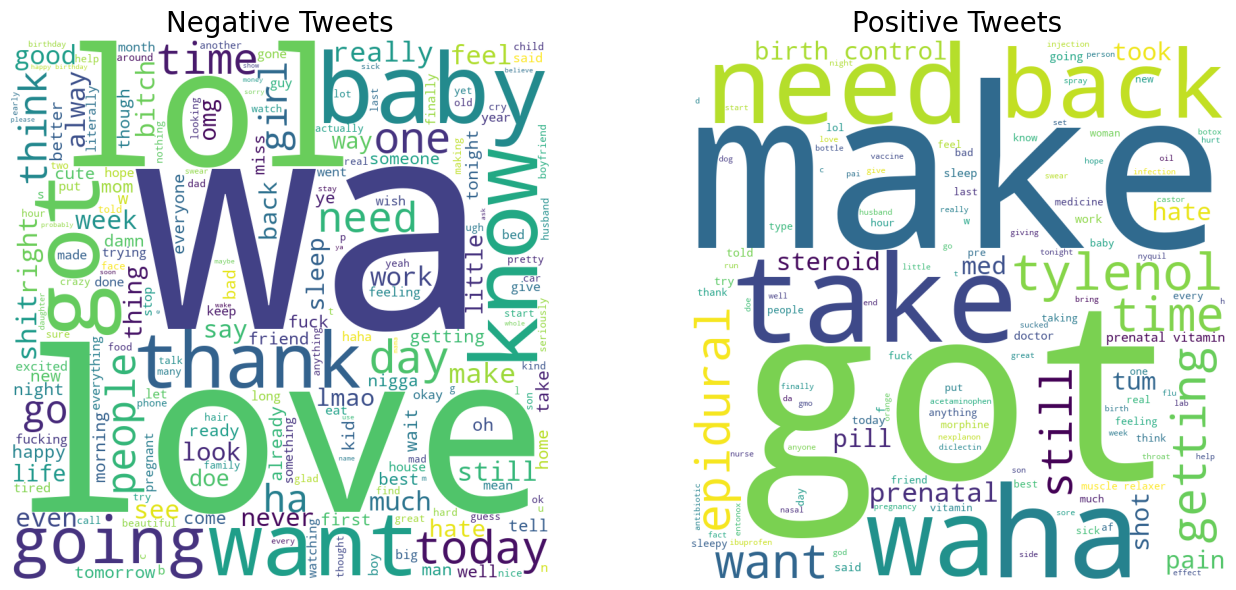

In [30]:
from wordcloud import STOPWORDS
# Plotting wordclouds for both negative and positive tweets
stopwords = set(STOPWORDS)

# Removing 'user' word as it does not hold any importance in our context
stopwords.add('user')        

negative_tweets = df_train['tweet'][df_train['class']==0].to_string()
wordcloud_negative = WordCloud(width = 800, height = 800, 
                               background_color ='white', stopwords = stopwords,
                               min_font_size = 10).generate(negative_tweets)

positive_tweets = df_train['tweet'][df_train['class']==1].to_string()
wordcloud_positive = WordCloud(width = 800, height = 800, 
                               background_color ='white', stopwords = stopwords,
                               min_font_size = 10).generate(positive_tweets)
 
# Plotting the WordCloud images
print('Training dataset')                     
plt.figure(figsize=(14, 6), facecolor = None)

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_negative)
plt.axis("off")
plt.title('Negative Tweets', fontdict={'fontsize': 20})

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_positive)
plt.axis("off")
plt.title('Positive Tweets', fontdict={'fontsize': 20})

plt.tight_layout() 
plt.show()



Testing dataset


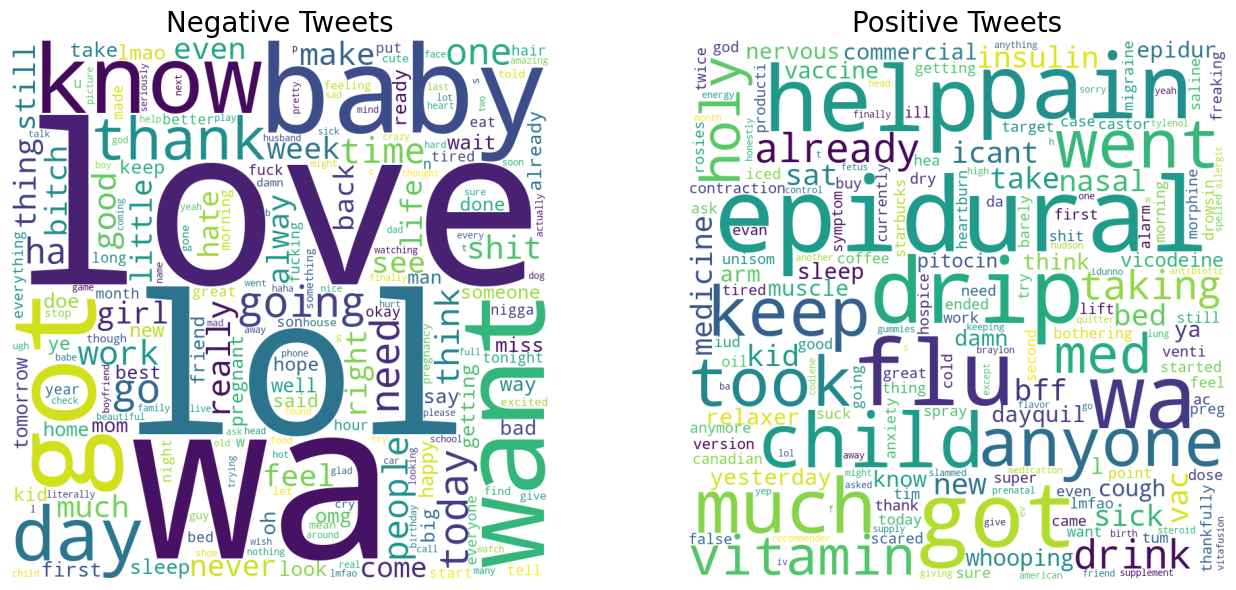

In [31]:
from wordcloud import STOPWORDS
# Plotting wordclouds for both negative and positive tweets
stopwords = set(STOPWORDS)

# Removing 'user' word as it does not hold any importance in our context
stopwords.add('user')        

negative_tweets = df_test['tweet'][df_test['label']==0].to_string()
wordcloud_negative = WordCloud(width = 800, height = 800, 
                               background_color ='white', stopwords = stopwords,
                               min_font_size = 10).generate(negative_tweets)

positive_tweets = df_test['tweet'][df_test['label']==1].to_string()
wordcloud_positive = WordCloud(width = 800, height = 800, 
                               background_color ='white', stopwords = stopwords,
                               min_font_size = 10).generate(positive_tweets)
 
# Plotting the WordCloud images
print('Testing dataset')                     
plt.figure(figsize=(14, 6), facecolor = None)

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_negative)
plt.axis("off")
plt.title('Negative Tweets', fontdict={'fontsize': 20})

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_positive)
plt.axis("off")
plt.title('Positive Tweets', fontdict={'fontsize': 20})

plt.tight_layout() 
plt.show()



In [32]:
#criaçao de X_train, y_train, X_test, y_test

X_train = df_train['tweet']
y_train = df_train['class']

X_test = df_test['tweet']
y_test = df_test['label']

In [33]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (55419,)
X_test shape:  (13853,)
y_train shape:  (55419,)
y_test shape:  (13853,)


In [34]:
def dummy_tokenizer(text):
    return text

In [35]:
tfidf = TfidfVectorizer(tokenizer= dummy_tokenizer, stop_words='english', lowercase=False)  

C:\Users\Paulo Seixal\AppData\Local\Temp\ipykernel_11576\1841016320.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train[df_train['class']==0][features[i]], label = 'Negative')
C:\Users\Paulo Seixal\AppData\Local\Temp\ipykernel_11576\1841016320.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn

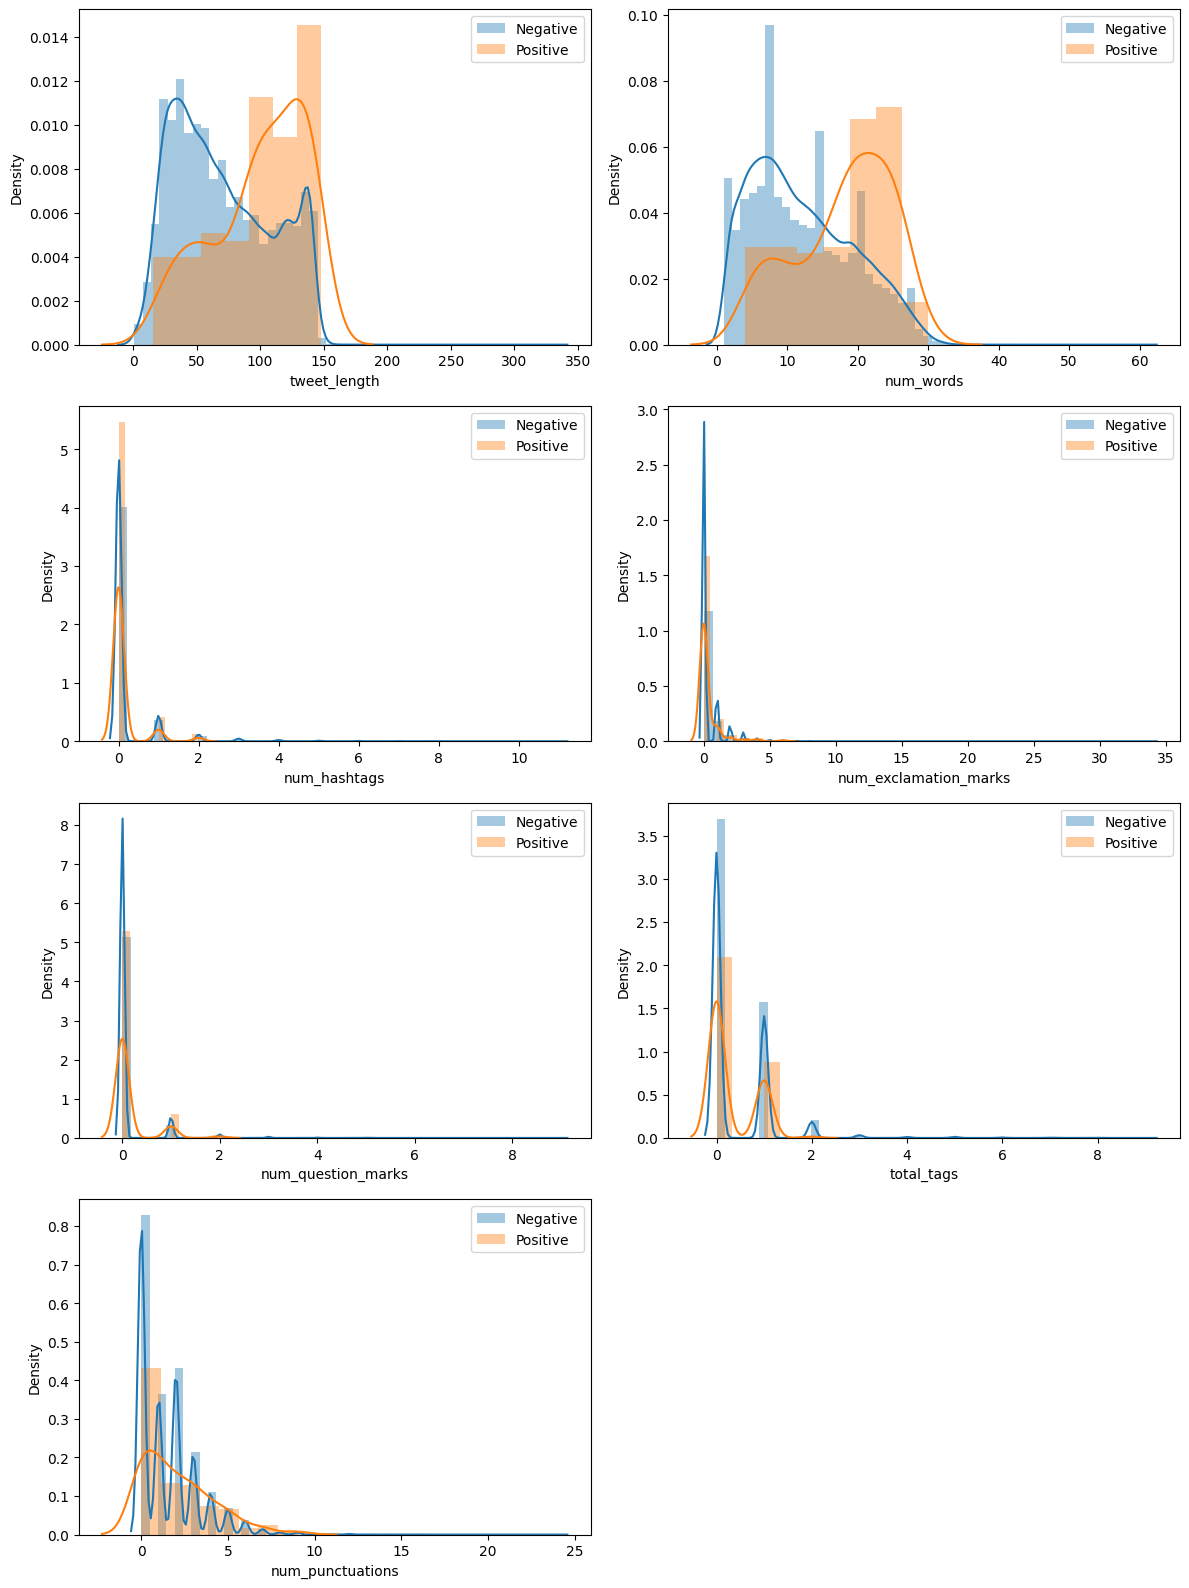

In [36]:
import seaborn as sns


# Visualizing relationship of newly created features
plt.figure(figsize=(12, 16))
features = ['tweet_length', 'num_words', 'num_hashtags', 'num_exclamation_marks', 'num_question_marks', 
            'total_tags', 'num_punctuations']
for i in range(len(features)):
    plt.subplot(4, 2, i+1)
    sns.distplot(df_train[df_train['class']==0][features[i]], label = 'Negative')
    sns.distplot(df_train[df_train['class']==1][features[i]], label = 'Positive')
    plt.legend()
plt.tight_layout()
plt.show()

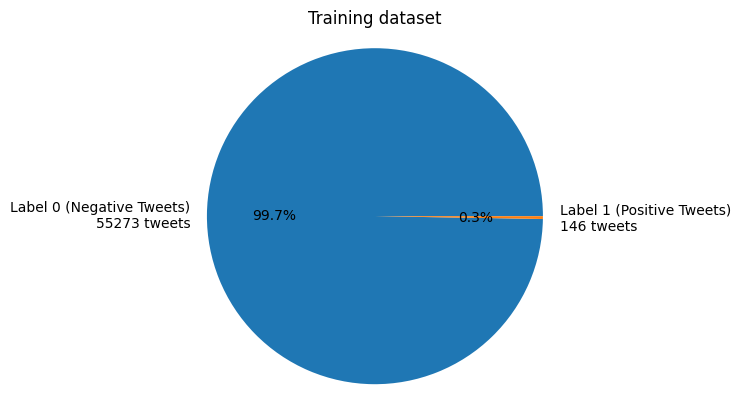

In [37]:
# Class Imbalance Check
plt.pie(df_train['class'].value_counts(), 
        labels=[f'Label 0 (Negative Tweets)\n{len(df_train[df_train["class"]==0])} tweets', f'Label 1 (Positive Tweets)\n{len(df_train[df_train["class"]==1])} tweets'], 
        autopct='%0.1f%%')
plt.axis('equal')
plt.title('Training dataset')
plt.show()

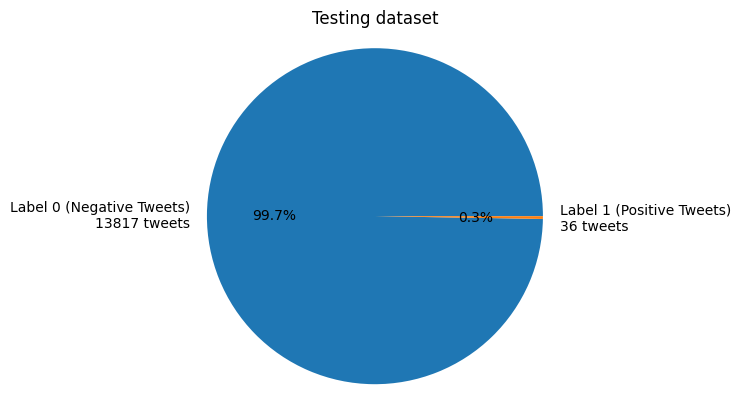

In [38]:
# Class Imbalance Check
plt.pie(df_test['label'].value_counts(), 
        labels=[f'Label 0 (Negative Tweets)\n{len(df_test[df_test["label"]==0])} tweets', f'Label 1 (Positive Tweets)\n{len(df_test[df_test["label"]==1])} tweets'], 
        autopct='%0.1f%%')
plt.axis('equal')
plt.title('Testing dataset')
plt.show()

### Smote

In [39]:
# Fit and transform the training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Fit and resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Transform the testing data
X_test_tfidf = tfidf.transform(X_test)


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


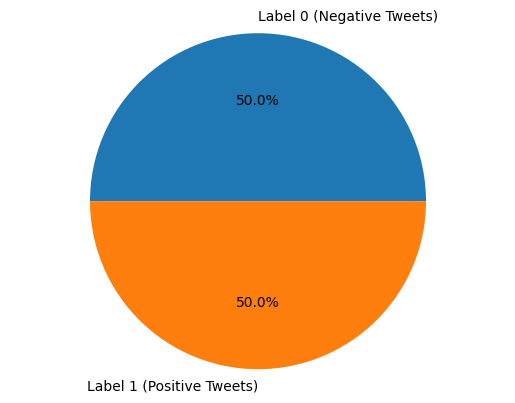

In [40]:
# Class Imbalance Check
plt.pie(pd.value_counts(y_train_resampled), 
        labels=['Label 0 (Negative Tweets)', 'Label 1 (Positive Tweets)'], 
        autopct='%0.1f%%')
plt.axis('equal')
plt.show()

In [41]:
df_train = pd.read_csv('task1_training.csv', delimiter = '\t')
df_test = pd.read_csv('task1_testing.csv', delimiter = '\t')

from process import BasicPreprocessor

processing = BasicPreprocessor()
processing.preprocess(df_train, 'tweet')
processing.preprocess(df_test, 'tweet')

In [42]:
def get_top_n_words(corpus, n=None, n_grams = 1, stopwords_removal = True):
    if stopwords_removal:
        vec = CountVectorizer(ngram_range=(n_grams,n_grams), stop_words='english').fit(corpus)
    else:
        vec = CountVectorizer(ngram_range=(n_grams,n_grams)).fit(corpus)
        
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### Unigrams

#### Training dataset

C:\Users\Paulo Seixal\AppData\Local\Temp\ipykernel_11576\3169862676.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
C:\Users\Paulo Seixal\AppData\Local\Temp\ipykernel_11576\3169862676.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


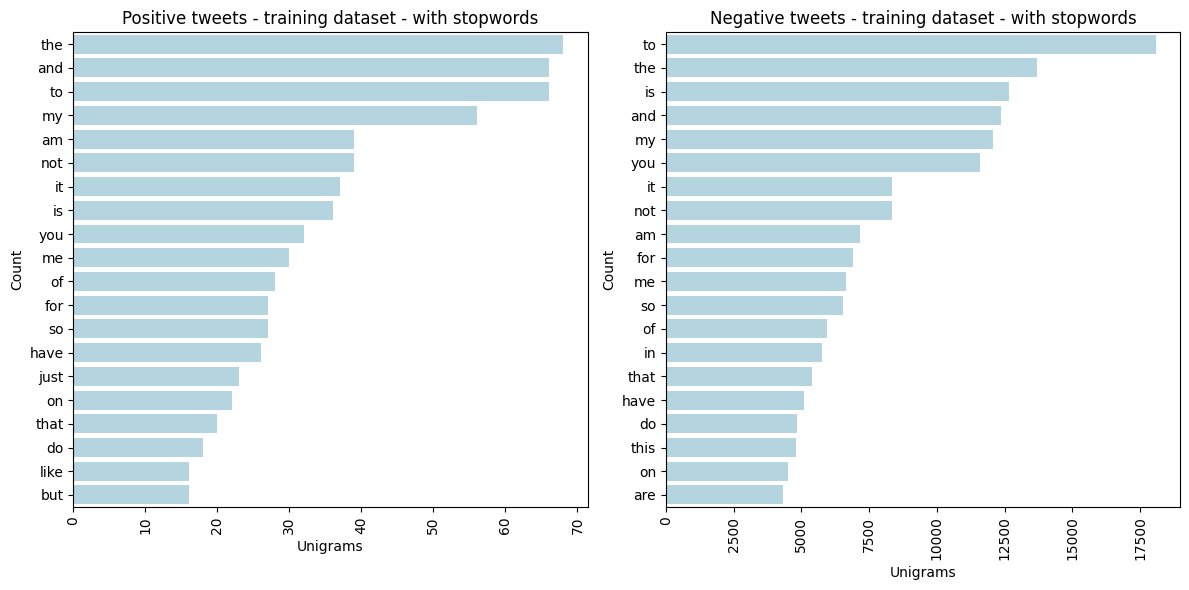

In [47]:
#unigrams before stopwords
common_words_train_pos = get_top_n_words(df_train.tweet[df_train['class'] == 1], 20, stopwords_removal= False)
common_words_train_neg = get_top_n_words(df_train.tweet[df_train['class'] == 0], 20, stopwords_removal= False)


df1 = pd.DataFrame(common_words_train_pos, columns = ['ReviewText' , 'count'])
grouped_data_pos = df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False)

df2 = pd.DataFrame(common_words_train_neg, columns = ['ReviewText' , 'count'])
grouped_data_neg = df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


# Plotting the first DataFrame
sns.barplot(x=grouped_data_pos.values, y=grouped_data_pos.index, ax=ax1, color='lightblue')
ax1.set_xlabel('Unigrams')
ax1.set_ylabel('Count')
ax1.set_title('Positive tweets - training dataset - with stopwords')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
# Plotting the second DataFrame
sns.barplot(x=grouped_data_neg.values, y=grouped_data_neg.index, ax=ax2, color='lightblue')
ax2.set_xlabel('Unigrams')
ax2.set_ylabel('Count')
ax2.set_title('Negative tweets - training dataset - with stopwords')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

# Adjusting the layout
plt.tight_layout()

# Displaying the plots
plt.show()

C:\Users\Paulo Seixal\AppData\Local\Temp\ipykernel_11576\1763911230.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
C:\Users\Paulo Seixal\AppData\Local\Temp\ipykernel_11576\1763911230.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


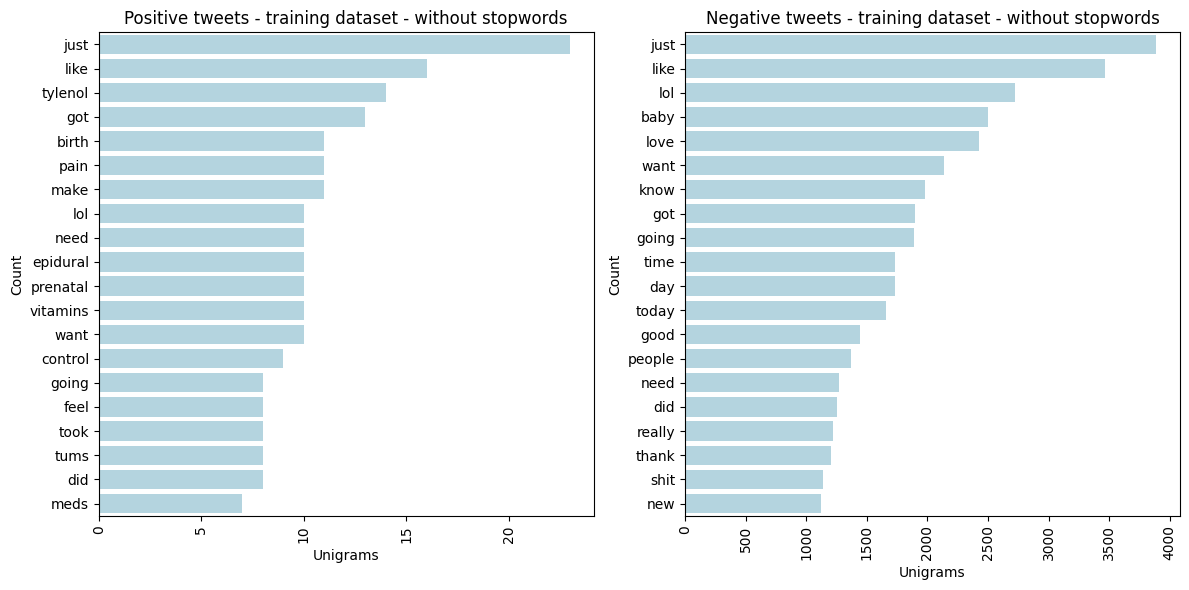

In [48]:
#unigrams after stopwords
common_words_train_pos = get_top_n_words(df_train.tweet[df_train['class'] == 1], 20, stopwords_removal= True)
common_words_train_neg = get_top_n_words(df_train.tweet[df_train['class'] == 0], 20, stopwords_removal= True)


df1 = pd.DataFrame(common_words_train_pos, columns = ['ReviewText' , 'count'])
grouped_data_pos = df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False)

df2 = pd.DataFrame(common_words_train_neg, columns = ['ReviewText' , 'count'])
grouped_data_neg = df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


# Plotting the first DataFrame
sns.barplot(x=grouped_data_pos.values, y=grouped_data_pos.index, ax=ax1, color='lightblue')
ax1.set_xlabel('Unigrams')
ax1.set_ylabel('Count')
ax1.set_title('Positive tweets - training dataset - without stopwords')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
# Plotting the second DataFrame
sns.barplot(x=grouped_data_neg.values, y=grouped_data_neg.index, ax=ax2, color='lightblue')
ax2.set_xlabel('Unigrams')
ax2.set_ylabel('Count')
ax2.set_title('Negative tweets - training dataset - without stopwords')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

# Adjusting the layout
plt.tight_layout()

# Displaying the plots
plt.show()

#### Testing dataset

C:\Users\Paulo Seixal\AppData\Local\Temp\ipykernel_11576\3692818327.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
C:\Users\Paulo Seixal\AppData\Local\Temp\ipykernel_11576\3692818327.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


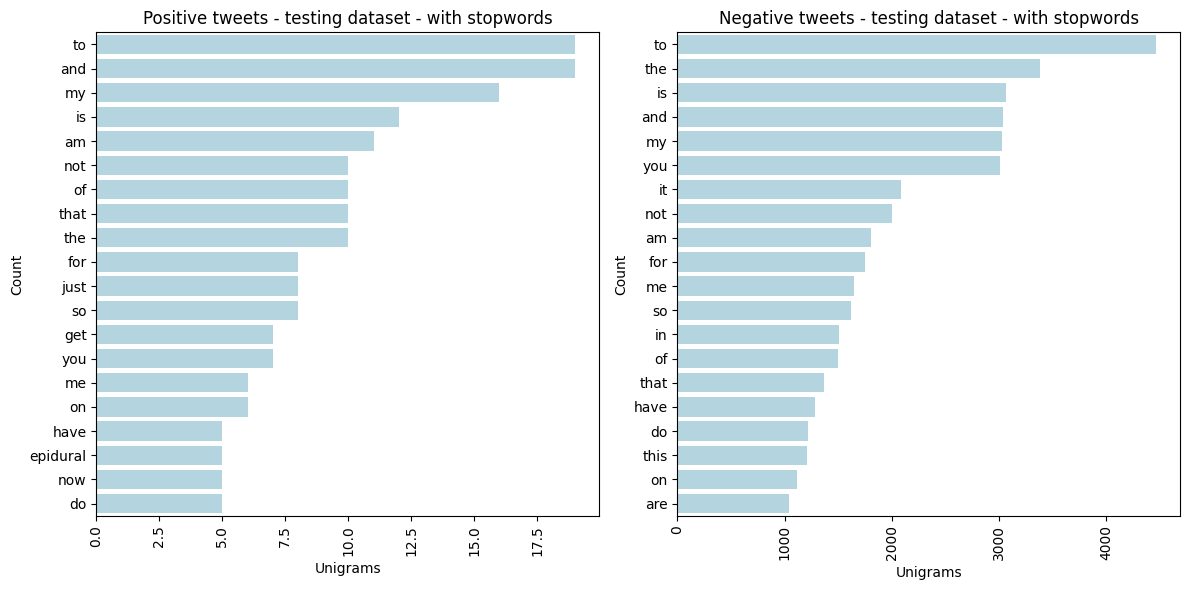

In [49]:
#unigrams before stopwords
common_words_train_pos = get_top_n_words(df_test.tweet[df_test['label'] == 1], 20, stopwords_removal= False)
common_words_train_neg = get_top_n_words(df_test.tweet[df_test['label'] == 0], 20, stopwords_removal= False)


df1 = pd.DataFrame(common_words_train_pos, columns = ['ReviewText' , 'count'])
grouped_data_pos = df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False)

df2 = pd.DataFrame(common_words_train_neg, columns = ['ReviewText' , 'count'])
grouped_data_neg = df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


# Plotting the first DataFrame
sns.barplot(x=grouped_data_pos.values, y=grouped_data_pos.index, ax=ax1, color='lightblue')
ax1.set_xlabel('Unigrams')
ax1.set_ylabel('Count')
ax1.set_title('Positive tweets - testing dataset - with stopwords')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
# Plotting the second DataFrame
sns.barplot(x=grouped_data_neg.values, y=grouped_data_neg.index, ax=ax2, color='lightblue')
ax2.set_xlabel('Unigrams')
ax2.set_ylabel('Count')
ax2.set_title('Negative tweets - testing dataset - with stopwords')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

# Adjusting the layout
plt.tight_layout()

# Displaying the plots
plt.show()

C:\Users\Paulo Seixal\AppData\Local\Temp\ipykernel_11576\12254992.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
C:\Users\Paulo Seixal\AppData\Local\Temp\ipykernel_11576\12254992.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


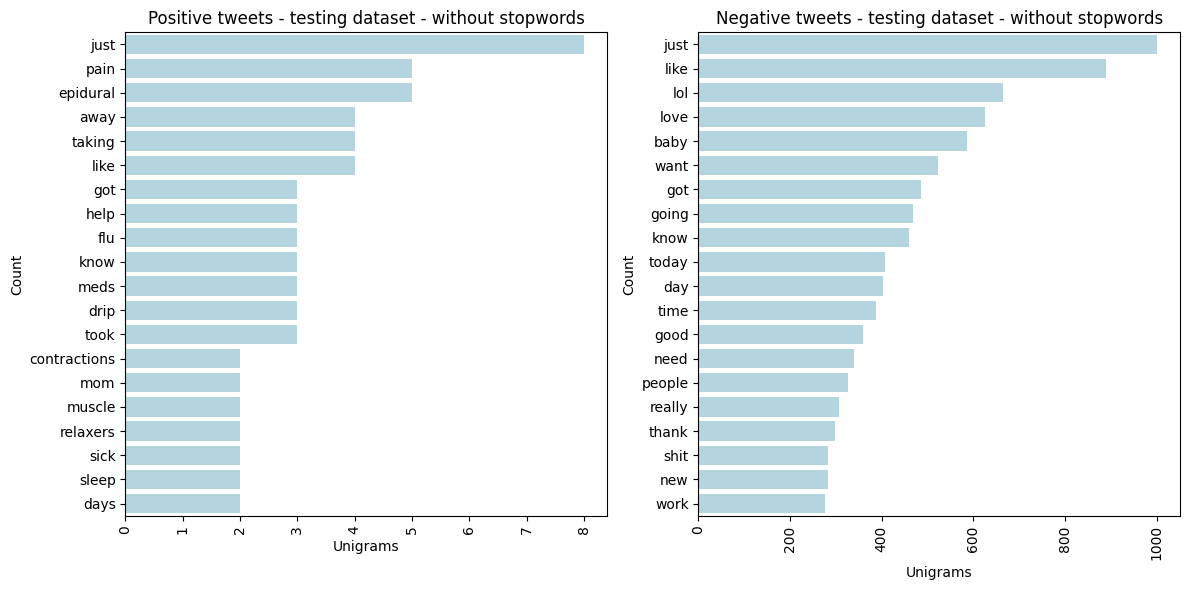

In [51]:
#unigrams after stopwords
common_words_test_pos = get_top_n_words(df_test.tweet[df_test['label'] == 1], 20, stopwords_removal= True)
common_words_test_neg = get_top_n_words(df_test.tweet[df_test['label'] == 0], 20, stopwords_removal= True)


df1 = pd.DataFrame(common_words_test_pos, columns = ['ReviewText' , 'count'])
grouped_data_pos = df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False)

df2 = pd.DataFrame(common_words_test_neg, columns = ['ReviewText' , 'count'])
grouped_data_neg = df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the first DataFrame

sns.barplot(x=grouped_data_pos.values, y=grouped_data_pos.index, ax=ax1, color='lightblue')
ax1.set_xlabel('Unigrams')
ax1.set_ylabel('Count')
ax1.set_title('Positive tweets - testing dataset - without stopwords')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
# Plotting the second DataFrame
sns.barplot(x=grouped_data_neg.values, y=grouped_data_neg.index, ax=ax2, color='lightblue')
ax2.set_xlabel('Unigrams')
ax2.set_ylabel('Count')
ax2.set_title('Negative tweets - testing dataset - without stopwords')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

# Adjusting the layout
plt.tight_layout()

# Displaying the plots
plt.show()

### Bigrams

#### Training dataset

C:\Users\Paulo Seixal\AppData\Local\Temp\ipykernel_11576\2246436419.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
C:\Users\Paulo Seixal\AppData\Local\Temp\ipykernel_11576\2246436419.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


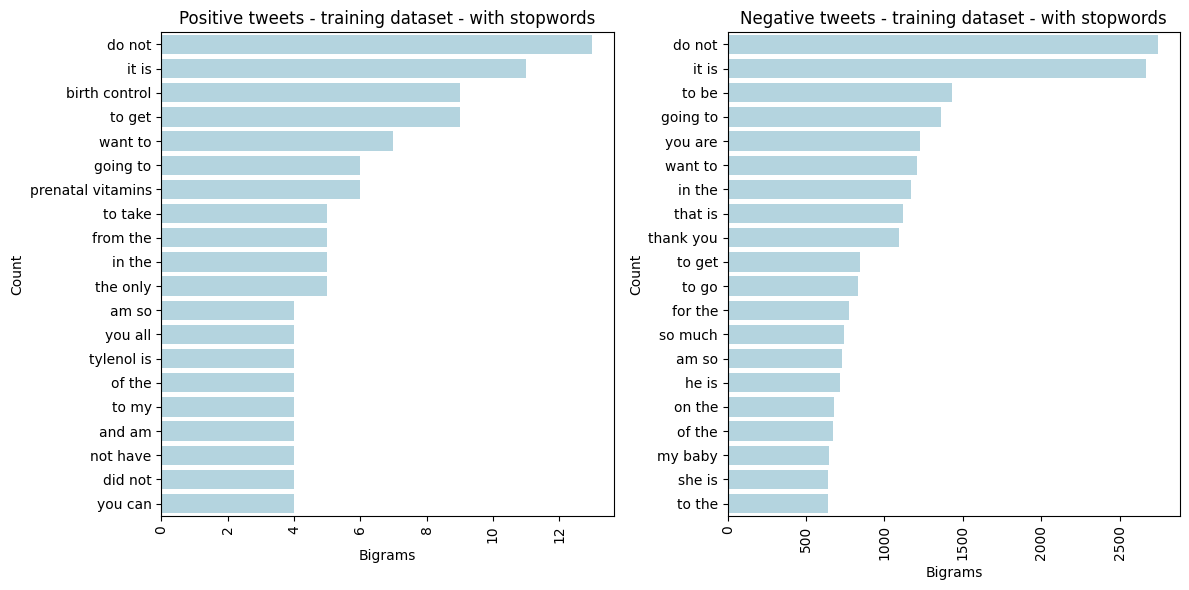

In [52]:
#unigrams before stopwords
common_words_train_pos = get_top_n_words(df_train.tweet[df_train['class'] == 1], 20,n_grams=2, stopwords_removal= False)
common_words_train_neg = get_top_n_words(df_train.tweet[df_train['class'] == 0], 20,n_grams=2, stopwords_removal= False)


df1 = pd.DataFrame(common_words_train_pos, columns = ['ReviewText' , 'count'])
grouped_data_pos = df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False)

df2 = pd.DataFrame(common_words_train_neg, columns = ['ReviewText' , 'count'])
grouped_data_neg = df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


# Plotting the first DataFrame
sns.barplot(x=grouped_data_pos.values, y=grouped_data_pos.index, ax=ax1, color='lightblue')
ax1.set_xlabel('Bigrams')
ax1.set_ylabel('Count')
ax1.set_title('Positive tweets - training dataset - with stopwords')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
# Plotting the second DataFrame
sns.barplot(x=grouped_data_neg.values, y=grouped_data_neg.index, ax=ax2,color='lightblue')
ax2.set_xlabel('Bigrams')
ax2.set_ylabel('Count')
ax2.set_title('Negative tweets - training dataset - with stopwords')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

# Adjusting the layout
plt.tight_layout()

# Displaying the plots
plt.show()

C:\Users\Paulo Seixal\AppData\Local\Temp\ipykernel_11576\4129689799.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
C:\Users\Paulo Seixal\AppData\Local\Temp\ipykernel_11576\4129689799.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


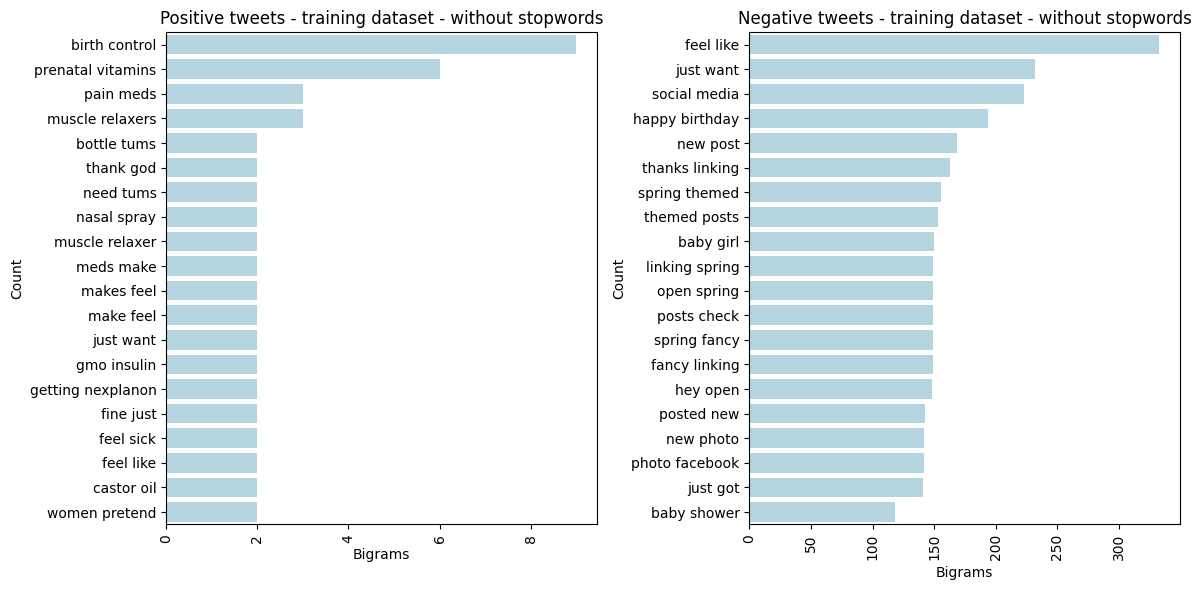

In [53]:
#unigrams after stopwords
common_words_train_pos = get_top_n_words(df_train.tweet[df_train['class'] == 1], 20, n_grams=2, stopwords_removal= True)
common_words_train_neg = get_top_n_words(df_train.tweet[df_train['class'] == 0], 20, n_grams=2, stopwords_removal= True)


df1 = pd.DataFrame(common_words_train_pos, columns = ['ReviewText' , 'count'])
grouped_data_pos = df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False)

df2 = pd.DataFrame(common_words_train_neg, columns = ['ReviewText' , 'count'])
grouped_data_neg = df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


# Plotting the first DataFrame
sns.barplot(x=grouped_data_pos.values, y=grouped_data_pos.index, ax=ax1, color='lightblue')
ax1.set_xlabel('Bigrams')
ax1.set_ylabel('Count')
ax1.set_title('Positive tweets - training dataset - without stopwords')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
# Plotting the second DataFrame
sns.barplot(x=grouped_data_neg.values, y=grouped_data_neg.index, ax=ax2, color='lightblue')
ax2.set_xlabel('Bigrams')
ax2.set_ylabel('Count')
ax2.set_title('Negative tweets - training dataset - without stopwords')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

# Adjusting the layout
plt.tight_layout()

# Displaying the plots
plt.show()

#### Testing dataset

C:\Users\Paulo Seixal\AppData\Local\Temp\ipykernel_11576\3499937124.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
C:\Users\Paulo Seixal\AppData\Local\Temp\ipykernel_11576\3499937124.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


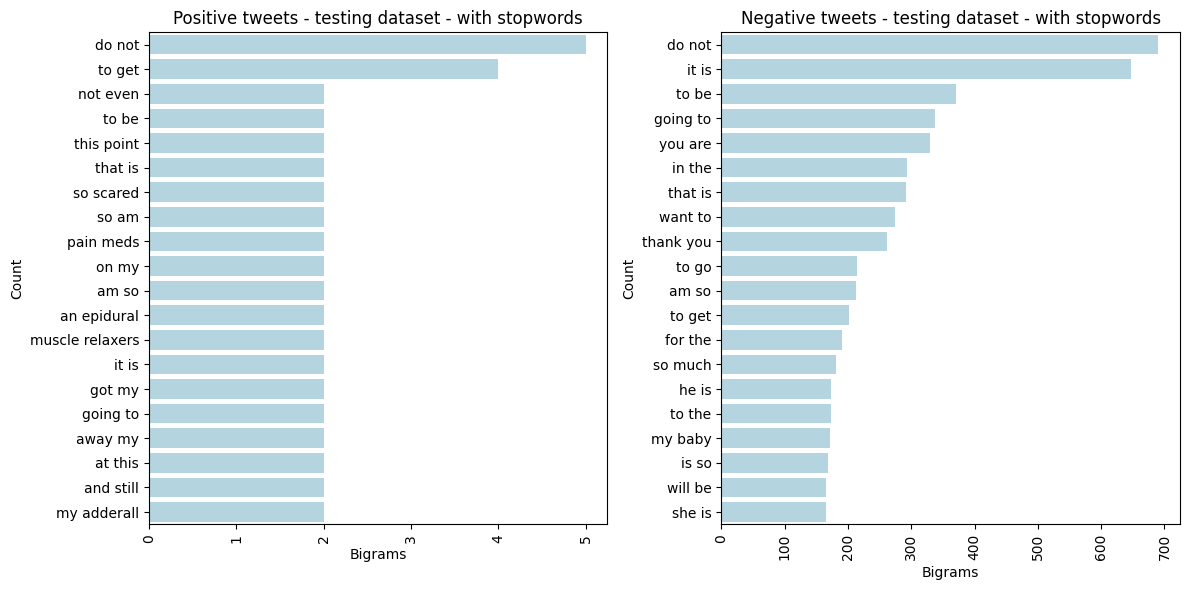

In [54]:
#unigrams before stopwords
common_words_train_pos = get_top_n_words(df_test.tweet[df_test['label'] == 1], 20,n_grams=2, stopwords_removal= False)
common_words_train_neg = get_top_n_words(df_test.tweet[df_test['label'] == 0], 20,n_grams=2, stopwords_removal= False)


df1 = pd.DataFrame(common_words_train_pos, columns = ['ReviewText' , 'count'])
grouped_data_pos = df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False)

df2 = pd.DataFrame(common_words_train_neg, columns = ['ReviewText' , 'count'])
grouped_data_neg = df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


# Plotting the first DataFrame
sns.barplot(x=grouped_data_pos.values, y=grouped_data_pos.index, ax=ax1, color='lightblue')
ax1.set_xlabel('Bigrams')
ax1.set_ylabel('Count')
ax1.set_title('Positive tweets - testing dataset - with stopwords')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
# Plotting the second DataFrame
sns.barplot(x=grouped_data_neg.values, y=grouped_data_neg.index, ax=ax2, color='lightblue')
ax2.set_xlabel('Bigrams')
ax2.set_ylabel('Count')
ax2.set_title('Negative tweets - testing dataset - with stopwords')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

# Adjusting the layout
plt.tight_layout()

# Displaying the plots
plt.show()

C:\Users\Paulo Seixal\AppData\Local\Temp\ipykernel_11576\986659590.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
C:\Users\Paulo Seixal\AppData\Local\Temp\ipykernel_11576\986659590.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


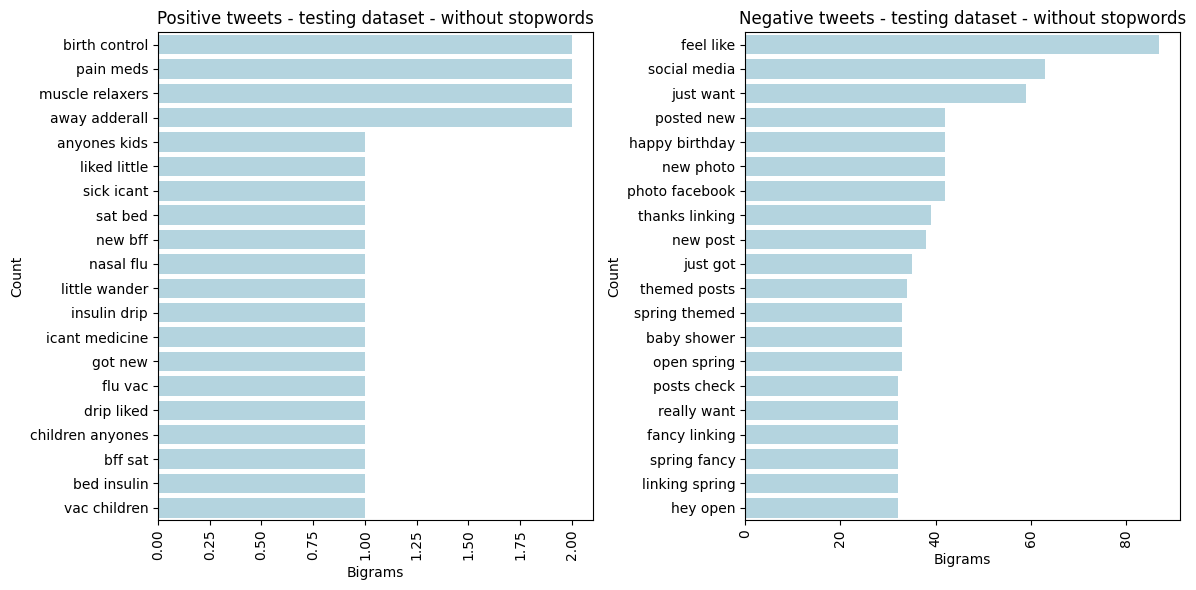

In [55]:
#bigrams after stopwords
common_words_train_pos = get_top_n_words(df_test.tweet[df_test['label'] == 1], 20,n_grams=2, stopwords_removal= True)
common_words_train_neg = get_top_n_words(df_test.tweet[df_test['label'] == 0], 20,n_grams=2, stopwords_removal= True)


df1 = pd.DataFrame(common_words_train_pos, columns = ['ReviewText' , 'count'])
grouped_data_pos = df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False)

df2 = pd.DataFrame(common_words_train_neg, columns = ['ReviewText' , 'count'])
grouped_data_neg = df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


# Plotting the first DataFrame
sns.barplot(x=grouped_data_pos.values, y=grouped_data_pos.index, ax=ax1, color='lightblue')
ax1.set_xlabel('Bigrams')
ax1.set_ylabel('Count')
ax1.set_title('Positive tweets - testing dataset - without stopwords')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
# Plotting the second DataFrame
sns.barplot(x=grouped_data_neg.values, y=grouped_data_neg.index, ax=ax2, color='lightblue')
ax2.set_xlabel('Bigrams')
ax2.set_ylabel('Count')
ax2.set_title('Negative tweets - testing dataset - without stopwords')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

# Adjusting the layout
plt.tight_layout()

# Displaying the plots
plt.show()